In [42]:
import os
import requests
from dotenv import load_dotenv
import pandas as pd
import pycountry
import pypopulation
from geojson import FeatureCollection, dump
import numpy as np
import xlrd
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, box
from shapely.ops import unary_union
from shapely import union_all

## Geocoding
Assigning countries coordinates

In [43]:
load_dotenv()
TOKEN=os.getenv("MAPBOX_TOKEN")
df = pd.read_csv("../output/processed/flows.csv") # ../output/processed/
origins = list(df.origin.unique())
destinations = list(df.destination.unique())


In [44]:
df

,Unnamed: 0,origin,destination,year,UN1,UN3,UN4.1,UN4.2,UN4.3,UN5.1,UN5.2,UN6.1,UN6.2,UN8,UN9,unspecified,multiple
0,0,ad,es,2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7777.400,0.00
1,1,ad,es,2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,486.800,0.00
2,2,ad,es,2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,425.980,0.00
3,3,ad,es,2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,621.950,0.00
4,4,ad,es,2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1044.092,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8114,8114,za,se,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.000,0.00
8115,8115,za,sg,2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,720.0,0.000,0.00
8116,8116,za,tr,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,21.24
8117,8117,zm,fi,2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,235.000,0.00


In [45]:
in_first = set(origins)
in_second = set(destinations)
in_second_but_not_in_first = in_second - in_first
countries = origins + list(in_second_but_not_in_first)

In [46]:
df = pd.DataFrame({"country":countries})
df

,country
0,ad
1,ae
2,af
3,al
4,am
...,...
150,as
151,kp
152,et
153,hk


In [47]:
headers = {'Accept': 'application/json'}
lst = []
for i in countries:
    obj = {}
    obj["type"]="Feature"
    obj["properties"]={"name": pycountry.countries.get(alpha_2=i).name}
    pop = pypopulation.get_population_a2(i)
    url = f"https://api.mapbox.com/geocoding/v5/mapbox.places/{pycountry.countries.get(alpha_2=i).name}.json?&types=country&access_token={TOKEN}"
    r = requests.get(url)
    jason = r.json()
    obj["properties"]["code"] = i.lower()
    coords = jason["features"][0]["center"]
    bbox = jason["features"][0]["bbox"]
    obj["geometry"] = {"type":"Point", "coordinates": coords}
    lst.append(obj)
    df.loc[df["country"] == i, "lat"] = coords[1]
    df.loc[df["country"] == i, "lon"] = coords[0]
    df.loc[df["country"] == i, "name"] = obj["properties"]["name"]
    df.loc[df["country"] == i, "population"] = pop
    df.loc[df["country"] == i, "bbox"] = str(bbox)
    if i in destinations and not i in origins:
        df.loc[df["country"] == i, "destination_only"] = True
    else:
        df.loc[df["country"] == i, "destination_only"] = False

In [48]:
print(df[df["country"]=="de"])

   country        lat        lon     name  population  \
34      de  51.133481  10.018343  Germany  83132799.0   

                                            bbox destination_only  
34  [5.866315, 47.270238, 15.041832, 55.1286491]            False  


In [49]:
print(df[df["country"]=="ge"])

   country        lat        lon     name  population  \
47      ge  42.176311  43.517448  Georgia   3720382.0   

                                            bbox destination_only  
47  [39.9902344, 41.055263, 46.73647, 43.586309]            False  


In [50]:
with open('../output/processed/countries.geojson', 'w') as f:
    dump(FeatureCollection(lst), f)

In [51]:
df['population'] = df['population'].fillna(0).astype(int)

In [52]:
# filling one country manually
df.loc[df[df["name"]=="Saint Barthélemy"].index, 'population'] = 10457
df = df.astype({'population':'str'})

## Clustering


In [53]:
# https://unstats.un.org/unsd/methodology/m49/overview/
regions = pd.read_excel("regions.xls")

In [54]:
def func(x):
    iso3 = pycountry.countries.get(alpha_2=x).alpha_3
    result = int(regions[regions["ISO-alpha3 Code"] == iso3]["Sub-region Code"].values[0])
    return result

df["sub_region_code"] = df.apply(lambda x: func(x["country"]), axis=1)

def func(x):
    iso3 = pycountry.countries.get(alpha_2=x).alpha_3
    result = regions[regions["ISO-alpha3 Code"] == iso3]["Sub-region Name"].values[0]
    return result

df["sub_region_name"] = df.apply(lambda x: func(x["country"]), axis=1)

def func(x):
    iso3 = pycountry.countries.get(alpha_2=x).alpha_3
    result = int(regions[regions["ISO-alpha3 Code"] == iso3]["Region Code"].values[0])
    return result

df["region_code"] = df.apply(lambda x: func(x["country"]), axis=1)

def func(x):
    iso3 = pycountry.countries.get(alpha_2=x).alpha_3
    result = regions[regions["ISO-alpha3 Code"] == iso3]["Region Name"].values[0]
    return result

df["region_name"] = df.apply(lambda x: func(x["country"]), axis=1)



In [74]:
regions_ = {"Europe": [50.954692, 14.710857],"Asia": [35.459903, 79.899961],"Americas": [9.816245, -83.985292 ], "Oceania": [-24.155138, 144.572012 ],"Africa": [3.018519, 23.495710 ]}

sub_regions = {"Southern Europe": [43.078547129148966, 11.322942551609177],"Western Asia": [29.55756090313516, 42.44329454726712],"Southern Asia": [29.706997, 70.905342], "Latin America and the Caribbean": [-3.217065, -64.771275 ],"Western Europe": [ 49.269893, 5.539730 ], "Australia and New Zealand": [-35.069432, 154.953651],"Eastern Europe": [61.225572, 58.129048 ],"Sub-Saharan Africa": [ -6.846378, 23.645431 ],"South-eastern Asia": [3.7475381775653744, 116.05633077644896],"Northern America": [46.273467, -102.378211 ],"Eastern Asia": [40.612380, 108.240696 ],"Northern Europe": [60.439321, 8.110377 ],"Northern Africa": [23.728513, 13.013446 ],"Central Asia": [45.52807689959419, 66.85787353846288],"Melanesia": [-10.293643, 150.675081],"Polynesia": [-12.974755091871536, -166.8581651283315]}

In [57]:
# def func(x):
#     bbox = (eval(x)[1],eval(x)[0],eval(x)[3],eval(x)[2])
#     return box(*bbox, ccw=True)
# df["polygon"] = df.apply(lambda x: func(x["bbox"]), axis=1)

In [58]:
# def centroids(typ):
#     obj = {}
#     for i in list(df[f"{typ}_name"].unique()):
#         polygons = list(df[df[f"{typ}_name"] == i]["polygon"])
#         u = union_all(polygons)
#         obj[i] = u.centroid
#     df[f"{typ}_lat"] = df.apply(lambda x: obj[x[f"{typ}_name"]].xy[0][0], axis=1)
#     df[f"{typ}_lon"] = df.apply(lambda x: obj[x[f"{typ}_name"]].xy[1][0], axis=1)

In [59]:
# gpd.GeoSeries(list(df[f"polygon"].unique())).plot()

In [60]:
# def centroids(typ):
#     obj = {}
#     for i in list(df[f"{typ}_name"].unique()):
#         lats = df[df[f"{typ}_name"] == i]["lat"]
#         lons = df[df[f"{typ}_name"] == i]["lon"]
#         lat = sum(lats)/len(lats)
#         lon = sum(lons)/len(lons)
#         obj[i] = [lat,lon]
#
#     df[f"{typ}_lat"] = df.apply(lambda x: obj[x[f"{typ}_name"]][0], axis=1)
#     df[f"{typ}_lon"] = df.apply(lambda x: obj[x[f"{typ}_name"]][1], axis=1)

In [61]:
# def centroids(typ):
#     obj = {}
#     for i in list(df[f"{typ}_name"].unique()):
#         polygons = list(df[df[f"{typ}_name"] == i]["polygon"])
#         u = union_all(polygons)
#         obj[i] = u.centroid
#     df[f"{typ}_lat"] = df.apply(lambda x: obj[x[f"{typ}_name"]].xy[0][0], axis=1)
#     df[f"{typ}_lon"] = df.apply(lambda x: obj[x[f"{typ}_name"]].xy[1][0], axis=1)
#
# df["region2_name"] = df["region_name"]
# df.loc[df["name"].isin(["Samoa","American Samoa"]), "region2_name"] = 0

In [75]:

df["region_lat"] = df.apply(lambda x: regions_[x["region_name"]][0], axis=1)
df["region_lon"] = df.apply(lambda x: regions_[x["region_name"]][1], axis=1)
df["sub_region_lat"] = df.apply(lambda x: sub_regions[x["sub_region_name"]][0], axis=1)
df["sub_region_lon"] = df.apply(lambda x: sub_regions[x["sub_region_name"]][1], axis=1)


In [69]:
# df.drop('region2_name', axis = 1, inplace=True)
# df.drop('polygon', axis = 1, inplace=True)
# df.drop('bbox', axis = 1, inplace=True)
# df.rename(columns={'region2_lat': "region_lat", "region2_lon": "region_lon" }, inplace=True)
df

,country,lat,lon,name,population,bbox,destination_only,sub_region_code,sub_region_name,region_code,region_name,region_lat,region_lon,sub_region_lat,sub_region_lon
0,ad,42.548654,1.576766,Andorra,77142,"[1.413638, 42.428731, 1.786451, 42.654863]",False,39,Southern Europe,150,Europe,50.954692,14.710857,43.078547,11.322943
1,ae,23.852060,54.256172,United Arab Emirates,9770529,"[51.4160156, 22.630837, 56.4788162, 26.1159859]",False,145,Western Asia,142,Asia,35.459903,79.899961,29.557561,42.443295
2,af,33.838806,66.026471,Afghanistan,38041754,"[60.473356, 29.377806, 74.885699, 38.49112]",False,34,Southern Asia,142,Asia,35.459903,79.899961,29.706997,70.905342
3,al,40.641090,20.156691,Albania,2854191,"[19.1679867, 39.6395376, 21.056921, 42.660312]",False,39,Southern Europe,150,Europe,50.954692,14.710857,43.078547,11.322943
4,am,40.605656,44.660395,Armenia,2957731,"[43.44828, 38.840232, 46.632954, 41.299872]",False,145,Western Asia,142,Asia,35.459903,79.899961,29.557561,42.443295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,as,-14.304405,-170.707833,American Samoa,55312,"[-171.1895385, -14.6659997, -168.030771, -10.9...",True,61,Polynesia,9,Oceania,-24.155138,144.572012,-11.724583,158.598780
151,kp,40.347099,126.847799,"Korea, Democratic People's Republic of",25666161,"[124.1680387, 37.5998322, 130.7826744, 43.008978]",True,30,Eastern Asia,142,Asia,35.459903,79.899961,40.612380,108.240696
152,et,8.626220,39.616032,Ethiopia,112078730,"[32.999665, 3.396106, 47.987795, 14.894214]",True,202,Sub-Saharan Africa,2,Africa,3.018519,23.495710,-6.846378,23.645431
153,hk,22.279356,114.162550,Hong Kong,7507400,"[113.7304687, 22.1059988, 114.5092444, 22.581928]",True,30,Eastern Asia,142,Asia,35.459903,79.899961,40.612380,108.240696


In [ ]:
# df.loc[df["name"].isin(["Samoa","American Samoa"]), "region_lat"] = df.loc[df["name"] == "Australia"]["region_lat"].values[0]
# df.loc[df["name"].isin(["Samoa","American Samoa"]), "region_lon"] = df.loc[df["name"] == "Australia"]["region_lon"].values[0]

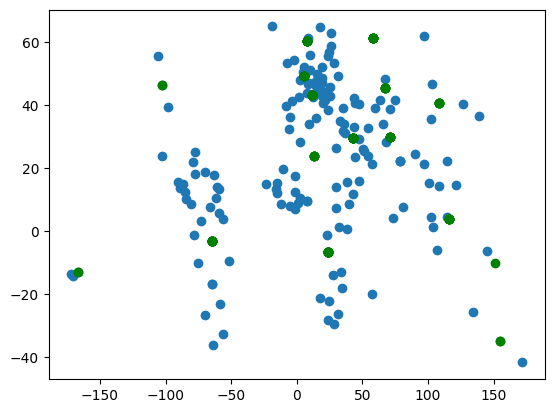

In [76]:
plt.scatter(df["lon"], df["lat"])
# plt.scatter(df["region_lon"], df["region_lat"], c="red")
plt.scatter(df["sub_region_lon"], df["sub_region_lat"], c="green")
plt.show()

In [77]:
df.rename(columns={"country": "code"}, inplace=True)

In [78]:
df = df[["code","name","lat","lon","region_code","region_name","region_lat","region_lon","sub_region_code","sub_region_name", "sub_region_lat", "sub_region_lon","population","destination_only"]]
df

,code,name,lat,lon,region_code,region_name,region_lat,region_lon,sub_region_code,sub_region_name,sub_region_lat,sub_region_lon,population,destination_only
0,ad,Andorra,42.548654,1.576766,150,Europe,50.954692,14.710857,39,Southern Europe,43.078547,11.322943,77142,False
1,ae,United Arab Emirates,23.852060,54.256172,142,Asia,35.459903,79.899961,145,Western Asia,29.557561,42.443295,9770529,False
2,af,Afghanistan,33.838806,66.026471,142,Asia,35.459903,79.899961,34,Southern Asia,29.706997,70.905342,38041754,False
3,al,Albania,40.641090,20.156691,150,Europe,50.954692,14.710857,39,Southern Europe,43.078547,11.322943,2854191,False
4,am,Armenia,40.605656,44.660395,142,Asia,35.459903,79.899961,145,Western Asia,29.557561,42.443295,2957731,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,as,American Samoa,-14.304405,-170.707833,9,Oceania,-24.155138,144.572012,61,Polynesia,-12.974755,-166.858165,55312,True
151,kp,"Korea, Democratic People's Republic of",40.347099,126.847799,142,Asia,35.459903,79.899961,30,Eastern Asia,40.612380,108.240696,25666161,True
152,et,Ethiopia,8.626220,39.616032,2,Africa,3.018519,23.495710,202,Sub-Saharan Africa,-6.846378,23.645431,112078730,True
153,hk,Hong Kong,22.279356,114.162550,142,Asia,35.459903,79.899961,30,Eastern Asia,40.612380,108.240696,7507400,True


In [79]:
df.to_csv("../output/processed/countries.csv", index=False)